## 策略逻辑：
1. 60分钟看长短期MA趋势， 15分钟做均线择时。
2. 加1：3的止损止盈比例，止损设置为3%

**止损需要写在onBar，以最快的速度成交**

In [4]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    fastPeriod = 20; slowPeriod = 40
    signalMaPeriod = 20
    stopRatio = 0.04
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'signalMaPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        #定义事件信号
        if fastMa[-1] > slowMa[-1]:
            self.maTrend[symbol] = 1
        else:
            self.maTrend[symbol] = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return

        signalMa = ta.EMA(am15.close, self.signalMaPeriod)

        maUp = signalMa[-1]>signalMa[-3] # 均线上涨
        maDn = signalMa[-1]<signalMa[-3] # 均线下跌
        
        # 均线上涨， 趋势为多头， 多头没有持仓
        if maUp and (self.maTrend[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 均线下跌， 趋势为空头， 空头没有持仓
        if maDn and (self.maTrend[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


## 配置引擎参数

In [5]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x12f93ad08>, <__main__.MultiFrameMaStrategy object at 0x12fc7f2e8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x12f92cf28>, <__main__.MultiFrameMaStrategy object at 0x12fc7f2e8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12f93a598>, <__main__.MultiFrameMaStrategy object at 0x12fc7f2e8>)
2018-12-04 21:58:23.892798	开始回测
2018-12-04 21:58:23.892883	策略初始化
2018-12-04 21:58:23.895413	载入历史数据。数据范围:[20180824 04:00,20180901 12:00)
2018-12-04 21:58:26.619324	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-04 21:58:26.631926	载入完成，数据量：12000
2018-12-04 21:58:26.633687	策略初始化完成
2018-12-04 21:58:26.635625	策略启动完成
2018-12-04 21:58:26.635756	开始回放回测数据,回测范围:[20180901 12:00,20181121 12:00)
2018-12-04 21:58:26.792223	载

2018-12-04 21:59:27.856094	数据回放结束ss: 100%    
2018-12-04 21:59:27.858423	计算按日统计结果
2018-12-04 21:59:27.948814	------------------------------
2018-12-04 21:59:27.949357	首个交易日：	2018-09-01 00:00:00
2018-12-04 21:59:27.949446	最后交易日：	2018-11-21 00:00:00
2018-12-04 21:59:27.949510	总交易日：	82
2018-12-04 21:59:27.949570	盈利交易日	43
2018-12-04 21:59:27.975748	亏损交易日：	38
2018-12-04 21:59:27.975839	起始资金：	100000
2018-12-04 21:59:27.975999	结束资金：	102,226.39
2018-12-04 21:59:27.976113	总收益率：	2.23%
2018-12-04 21:59:27.976215	年化收益：	6.52%
2018-12-04 21:59:27.976292	总盈亏：	2,226.39
2018-12-04 21:59:27.976380	最大回撤: 	-408.37
2018-12-04 21:59:27.976468	百分比最大回撤: -0.41%
2018-12-04 21:59:27.976538	总手续费：	388.41
2018-12-04 21:59:27.976604	总滑点：	0.24
2018-12-04 21:59:27.976669	总成交金额：	776,821.7
2018-12-04 21:59:27.976728	总成交笔数：	121
2018-12-04 21:59:27.976786	日均盈亏：	27.15
2018-12-04 21:59:27.976844	日均手续费：	4.74
2018-12-04 21:59:27.976902	日均滑点：	0.0
2018-12-04 21:59:27.976963	日均成交金额：	9,473.44
2018-12-04 21:59:27.977024	日均成交笔数：	1.

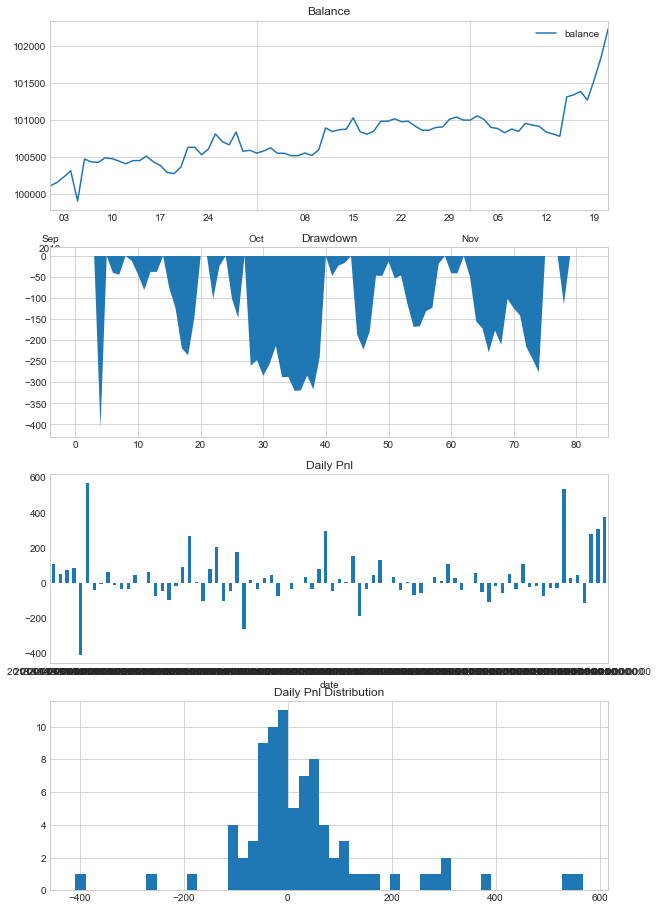

2018-12-04 21:59:32.720956	计算回测结果
2018-12-04 21:59:32.736934	------------------------------
2018-12-04 21:59:32.737111	第一笔交易：	2018-09-04 06:45:00
2018-12-04 21:59:32.737173	最后一笔交易：	2018-11-21 11:58:00
2018-12-04 21:59:32.737233	总交易次数：	61
2018-12-04 21:59:32.737296	总盈亏：	2,224.06
2018-12-04 21:59:32.737354	最大回撤: 	-964.09
2018-12-04 21:59:32.737472	平均每笔盈利：	36.46
2018-12-04 21:59:32.737526	平均每笔滑点：	0.0
2018-12-04 21:59:32.737580	平均每笔佣金：	6.41
2018-12-04 21:59:32.737633	胜率		26.23%
2018-12-04 21:59:32.737919	盈利交易平均值	319.33
2018-12-04 21:59:32.737997	亏损交易平均值	-64.11
2018-12-04 21:59:32.738060	盈亏比：	4.98


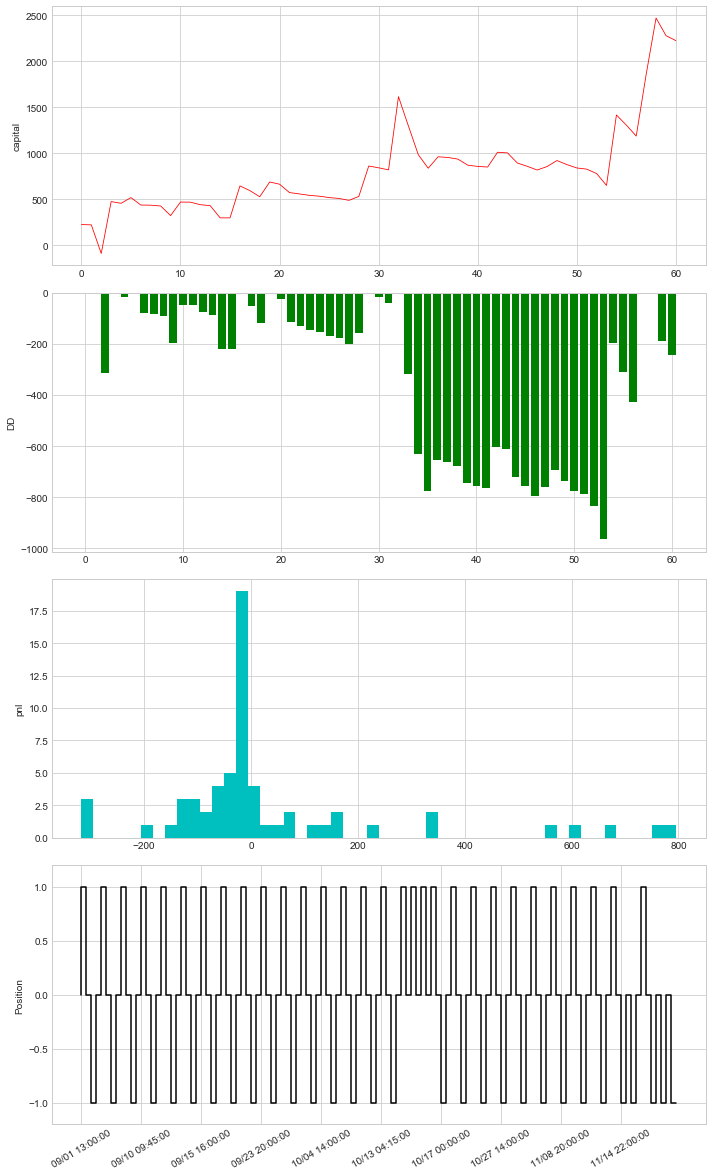

2018-12-04 21:59:34.954355	计算按日统计结果


(                netPnl  slippage  commission  turnover  tradeCount  \
 date                                                                 
 2018-09-01  108.980990     0.002    3.527010   7054.02           1   
 2018-09-02   47.710000     0.000    0.000000      0.00           0   
 2018-09-03   73.780000     0.000    0.000000      0.00           0   
 2018-09-04   83.629370     0.008   14.572630  29145.26           4   
 2018-09-05 -408.367265     0.004    6.983265  13966.53           2   
 2018-09-06  567.510000     0.000    0.000000      0.00           0   
 2018-09-07  -39.899840     0.004    6.415840  12831.68           2   
 2018-09-08   -4.597450     0.004    6.403450  12806.90           2   
 2018-09-09   60.350000     0.000    0.000000      0.00           0   
 2018-09-10  -11.468960     0.004    6.334960  12669.92           2   
 2018-09-11  -32.414110     0.004    6.260110  12520.22           2   
 2018-09-12  -36.835200     0.008   12.507200  25014.40           4   
 2018-

In [6]:
parameterDict = {'symbolList':['BTCUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180901 12:00', '20181121 12:00', 0.002, 5/10000)